## OVERVIEW
---
* Image Preprocessing with OpenCV
    * Masking
    * Segmentation
    * Image Sharpening
* Transfer Learning with Keras Pretrained Model
* Feature Extraction
* Deep Learning Model to Classify the Images

In [145]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform
from PIL import Image

from tqdm import tqdm
from glob import glob
import random


from keras.models import Model, Sequential
from keras import models
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking,Flatten
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from keras.preprocessing.image import *
from skimage import io

from sklearn.preprocessing import OneHotEncoder

from datetime import datetime

MAX_NORMAL_IMAGE = 800

In [146]:
base_folder = '../dataset'
fire_data_folder = '../dataset/fire'
flood_data_folder = '../dataset/flood'
augmented_flood_data_folder = '../dataset/flood/augmented'
normal_data_folder = '../dataset/normal'
fire_data_folder = '../dataset/fire'
train_data_folder = '../dataset/fire'

categories = ['fire', 'flood', 'normal']
len_categories = len(categories)

In [114]:
### RENAME NORMAL DATA

In [115]:

# i=1
# for path in os.listdir(normal_data_folder):
#      real_path=os.path.join(normal_data_folder, path)
#      new_name=f"image_{i}.jpg"
#      new_path=os.path.join(normal_data_folder, new_name)
#      print(f"path is: {real_path}")
#      os.rename(real_path,new_path)
#      i=i+1
    
# for path in os.listdir(os.path.join(normal_data_folder)):
#     real_path=os.path.join(normal_data_folder, path)
#     print(f"path is: {real_path}")

### AUGUMENTATION FUNCTIONS

In [147]:
def delete_augumented_data(custom_image_directory):
    for f in glob(custom_image_directory+"/image_aug*"):
        #print(f)
        os.remove(f)
        
def augument_data(custom_image_directory,multiple_of_ten):
    datagen = ImageDataGenerator(        
            rotation_range = 0,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            brightness_range = (0.5, 1.5))

    image_directory = custom_image_directory
    SIZE = 255
    dataset = []
    my_images = os.listdir(image_directory)
    for i, image_name in enumerate(my_images):   
        try:
            extension = image_name.split('.')[-1] 
            image = io.imread(image_directory +'\\'+ image_name)        
            image = Image.fromarray(image, 'RGB')        
            image = image.resize((SIZE,SIZE)) 
            dataset.append(np.array(image))
        except Exception as e:
            #print(f"exception is: {e}")
            pass
    x = np.array(dataset)
    i = 0
    for batch in datagen.flow(x, batch_size=10,
                              save_to_dir= image_directory,
                              save_prefix=f"image_aug",
                              save_format=extension):    
        i += 1    
        if i >= multiple_of_ten:        
            break

### DELETE AUGMENTED IMAGE

In [148]:
delete_augumented_data(fire_data_folder)
delete_augumented_data(flood_data_folder)

### IMAGE AUGUMENTATION

In [149]:
#augument_data(fire_data_folder,425)
augument_data(flood_data_folder,36)

In [150]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(base_folder, category)
    label = category
    image_count[category] = []
    
    if category == 'normal':
        random_sample = random.sample(glob(class_folder+'/*'), MAX_NORMAL_IMAGE)
        for path in random_sample:
            image_count[category].append(category)
            name =path.split('\\')[-1]
            train_data.append(['{}/{}'.format(category, name), i, category])  
    elif category == 'flood':
        paths = glob(class_folder+'/**/*.jpg', recursive=True)
        for path in paths:
           #print(f"these are the paths: {path}")
            image_count[category].append(category)
            name =path.split('\\')[-1]
            train_data.append(['{}/{}'.format(category, name), i, category])
    else:
        for path in os.listdir(os.path.join(class_folder)):
            image_count[category].append(category)
            train_data.append(['{}/{}'.format(category, path), i, category])
    

3it [00:01,  1.76it/s]


In [151]:
#show image count
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire -> 755
flood -> 801
normal -> 800


In [152]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()
df.tail()

(2356, 3)

,file,id,label
0,fire/fire.1.png,0,fire
1,fire/fire.10.png,0,fire
2,fire/fire.100.png,0,fire
3,fire/fire.101.png,0,fire
4,fire/fire.102.png,0,fire


,file,id,label
2351,normal/image_4604.jpg,2,normal
2352,normal/image_1706.jpg,2,normal
2353,normal/image_17013.jpg,2,normal
2354,normal/image_11519.jpg,2,normal
2355,normal/image_7259.jpg,2,normal


### ONE HOT ENCODING

In [153]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'id' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['id']]).toarray())

#merge one-hot encoded columns back with original DataFrame
df = df.join(encoder_df)

df.drop('id', axis=1, inplace=True)

df.columns = ['file', 'label', 'fire', 'flood','normal']

In [154]:
df.head()
df.tail()

,file,label,fire,flood,normal
0,fire/fire.1.png,fire,1.0,0.0,0.0
1,fire/fire.10.png,fire,1.0,0.0,0.0
2,fire/fire.100.png,fire,1.0,0.0,0.0
3,fire/fire.101.png,fire,1.0,0.0,0.0
4,fire/fire.102.png,fire,1.0,0.0,0.0


,file,label,fire,flood,normal
2351,normal/image_4604.jpg,normal,0.0,0.0,1.0
2352,normal/image_1706.jpg,normal,0.0,0.0,1.0
2353,normal/image_17013.jpg,normal,0.0,0.0,1.0
2354,normal/image_11519.jpg,normal,0.0,0.0,1.0
2355,normal/image_7259.jpg,normal,0.0,0.0,1.0


### IMAGE PREPROCESSING

In [155]:
# #masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    path =os.path.join(base_folder, filepath);
    #print(f"filepath passed is: {filepath} and full path is: {path}")
    img = image.load_img(path, target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

### SHOW SAMPLE IMAGES

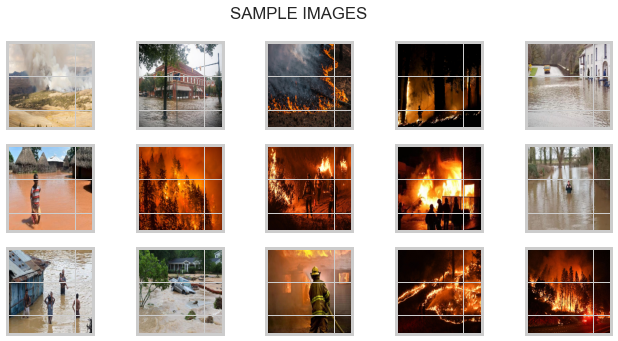

In [156]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.);
plt.show();

### SHOW SAMPLE PROCESSED IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


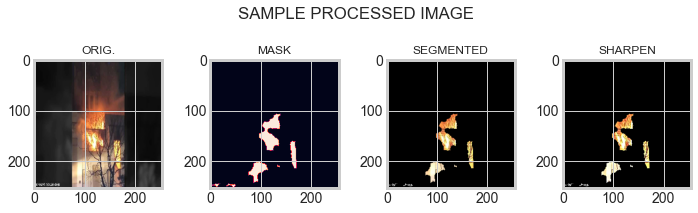

In [157]:
#get an image
img = read_img(df['file'][102],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout()

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);



### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [172]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

2356it [00:22, 102.66it/s]


In [173]:
# INPUT_SIZE=255
# X_train = np.zeros((1, INPUT_SIZE, INPUT_SIZE, 3), dtype='float')

# def batch_feature_extraction(start_index,end_index):
#     X_train_batch = np.zeros((1000, INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
#     for index in range(start_index,end_index):
#         diff=index-start_index
#         my_path = df.iloc[index,0]
#         print(f"{index} ",end=" ")
#         #print(f"file path is: {my_path}")
#         img = read_img(my_path,(INPUT_SIZE,INPUT_SIZE))
#         #masking and segmentation
#         image_segmented = segment_image(img)
#         #sharpen
#         image_sharpen = sharpen_image(image_segmented)
#         x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
#         #x = xception.preprocess_input(image_sharpen)
#         #X_train=np.append(X_train,[x],axis=0)
#         X_train_batch[diff]=x
#     return X_train_batch

In [174]:
# data_length = len(df)
# batch_size= 1000
# start_index=0
# end_index=0

# while start_index < data_length:
#     end_index=end_index+batch_size
#     end_index=end_index if end_index<data_length else data_length-1
#     print(f"start index is: {start_index} and end index is: {end_index}")
#     result=batch_feature_extraction(start_index,end_index)
#     X_train=np.append(X_train,result,axis=0)
#     start_index=end_index+1

In [175]:
#X_train = np.delete(X_train, (0), axis=0)

In [176]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (2356, 255, 255, 3)
Train Image Size:  459596700


#### SPLIT THE DATA

In [177]:
y = df[['fire','flood','normal']]
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [178]:
print('FIRE IMAGES ON TRAINING DATA: ',y['fire'].value_counts()[1])
print('FLOOD IMAGES ON TRAINING DATA: ',y['flood'].value_counts()[1])
print('NORMAL IMAGES ON TRAINING DATA: ',y['normal'].value_counts()[1])


FIRE IMAGES ON TRAINING DATA:  755
FLOOD IMAGES ON TRAINING DATA:  801
NORMAL IMAGES ON TRAINING DATA:  800


In [179]:
print(f"shapes are: {train_x.shape} {train_val.shape} {y_train.shape} {y_val.shape}")

shapes are: (1884, 255, 255, 3) (472, 255, 255, 3) (1884, 3) (472, 3)


In [180]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

15/15 [==============================] - 42s 3s/step


In [181]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (1884, 2048)
Train Size:  3858432
Validation Shape:  (472, 2048)
Validation Size:  966656


### DEEP LEARNING MODEL

In [182]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_33 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 195       
Total params: 541,187
Trainable params: 541,187
Non-trainable params: 0
_________________________________________________________________


In [183]:
#train the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
59/59 [==============================] - 1s 5ms/step - loss: 0.8499 - accuracy: 0.6024
Epoch 2/100
59/59 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.7542
Epoch 3/100
59/59 [==============================] - 0s 5ms/step - loss: 0.5332 - accuracy: 0.7760
Epoch 4/100
59/59 [==============================] - 0s 4ms/step - loss: 0.4763 - accuracy: 0.7994
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 0.4149 - accuracy: 0.8355
Epoch 6/100
59/59 [==============================] - 0s 4ms/step - loss: 0.3837 - accuracy: 0.8583
Epoch 7/100
59/59 [==============================] - 0s 4ms/step - loss: 0.3782 - accuracy: 0.8530
Epoch 8/100
59/59 [==============================] - 0s 4ms/step - loss: 0.3369 - accuracy: 0.8742
Epoch 9/100
59/59 [==============================] - 0s 4ms/step - loss: 0.3647 - accuracy: 0.8540
Epoch 10/100
59/59 [==============================] - 0s 4ms/step - loss: 0.3433 - accuracy: 0.8631
Epoch 11/

59/59 [==============================] - 0s 4ms/step - loss: 0.1175 - accuracy: 0.9538
Epoch 84/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0867 - accuracy: 0.9708
Epoch 85/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0926 - accuracy: 0.9687
Epoch 86/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0613 - accuracy: 0.9793
Epoch 87/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0904 - accuracy: 0.9703
Epoch 88/100
59/59 [==============================] - 0s 4ms/step - loss: 0.1087 - accuracy: 0.9628
Epoch 89/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0935 - accuracy: 0.9660
Epoch 90/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9687
Epoch 91/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9793
Epoch 92/100
59/59 [==============================] - 0s 4ms/step - loss: 0.0857 - accuracy: 0.9697
Epoch 93/100


#### LOSS AND ACCURACY

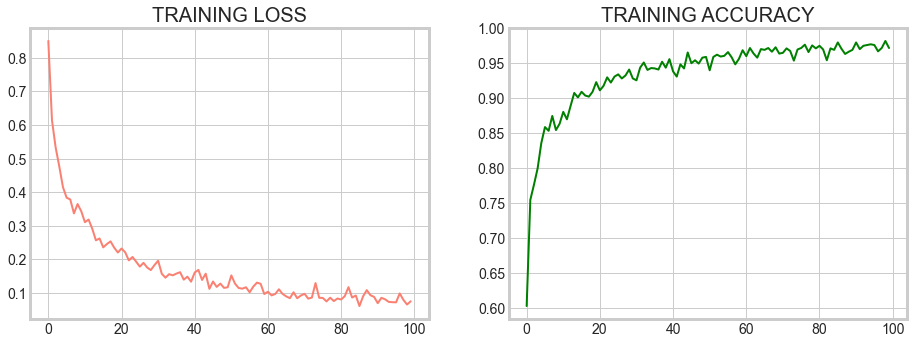

In [184]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [185]:
#predict the validation data
predictions = (model.predict(bf_train_val) > 0.5).astype("int32") #model.predict_classes(bf_train_val)

#### CLASSIFICATION REPORT

In [187]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       158
           1       0.87      0.84      0.85       164
           2       0.91      0.83      0.87       150

   micro avg       0.88      0.88      0.88       472
   macro avg       0.88      0.88      0.88       472
weighted avg       0.88      0.88      0.88       472
 samples avg       0.88      0.88      0.88       472



C:\Users\RILLO\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### CONFUSION MATRIX

shape of yval is: (472, 3) and predictions shape is: (472, 3)


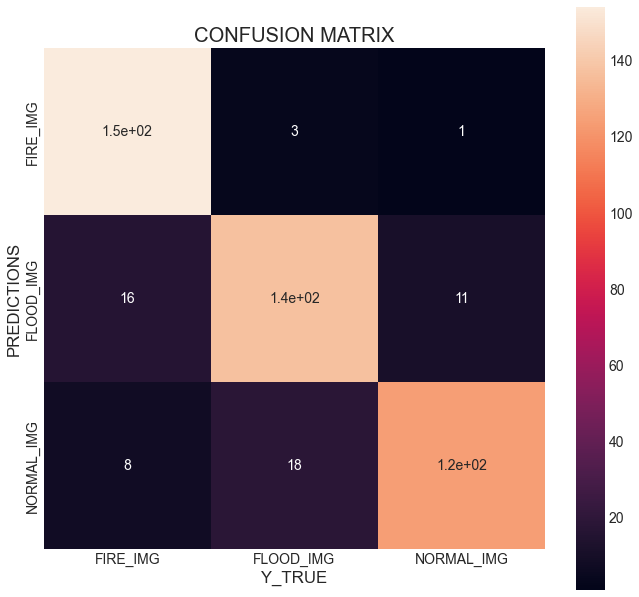

In [188]:
confusion_mat = confusion_matrix(y_val.values.argmax(axis=1), predictions.argmax(axis=1))
print(f"shape of yval is: {y_val.shape} and predictions shape is: {predictions.shape}")
plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'FLOOD_IMG', 'NORMAL_IMG'],
            xticklabels=['FIRE_IMG', 'FLOOD_IMG', 'NORMAL_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

In [189]:
## SAVE MODEL

In [190]:
saved_model_dir = '../output/model/'
model_name = saved_model_dir+f"model_{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.h5"
print(f"model name is: {model_name}")
model.save(model_name)

model name is: ../output/model/model_07_26_2022_17_41_18.h5
